In [1]:
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import os
import random
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


https://figshare.com/articles/dataset/Indoor-Outdoor_dataset/4595323

In [42]:
def sample_images_from_dataset(dataset_type, num_samples=10):
    indoor_folder_path = Path("sample_images/indoor")
    outdoor_folder_path = Path("sample_images/outdoor")
    ignatius_path = Path("../Ignatius")

    if dataset_type == "indoor":
        folder_path = indoor_folder_path
    elif dataset_type == "outdoor":
        folder_path = outdoor_folder_path
    elif dataset_type == "ignatius":
        folder_path = ignatius_path
    else:
        raise ValueError("Invalid dataset type. Choose from 'indoor', 'outdoor', or 'ignatius'.")

    selected_images = random.sample(os.listdir(folder_path), num_samples)
    images = []
    for i in range(num_samples):
        image = cv2.imread(str(folder_path / selected_images[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        # Check that shapes are reasonable
        #print(image.shape)
    
    return images

images = sample_images_from_dataset("indoor", num_samples=10)

https://github.com/LiheYoung/Depth-Anything

In [5]:
# Import depth anything model small, base, and large
processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf").to("cuda")
print(model.config)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DepthAnythingConfig {
  "_attn_implementation_autoset": true,
  "_commit_hash": "27ccb0920352c0c37b3a96441873c8d37bd52fb6",
  "_name_or_path": "LiheYoung/depth-anything-large-hf",
  "architectures": [
    "DepthAnythingForDepthEstimation"
  ],
  "backbone": null,
  "backbone_config": {
    "architectures": [
      "Dinov2Model"
    ],
    "hidden_size": 1024,
    "image_size": 518,
    "model_type": "dinov2",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "out_features": [
      "stage21",
      "stage22",
      "stage23",
      "stage24"
    ],
    "out_indices": [
      21,
      22,
      23,
      24
    ],
    "reshape_hidden_states": false,
    "stage_names": [
      "stem",
      "stage1",
      "stage2",
      "stage3",
      "stage4",
      "stage5",
      "stage6",
      "stage7",
      "stage8",
      "stage9",
      "stage10",
      "stage11",
      "stage12",
      "stage13",
      "stage14",
      "stage15",
      "stage16",
      "stage17",
      "stage1

In [44]:
# Pre process images

# USe only the images creates from the sample_images_from_dataset function and pass them through the model to get depth

def get_depth_map(images):
    num_samples = len(images)
    samples = []
    for i in range(num_samples):
        input = processor(images=images[i], return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model(**input)
            depth = outputs.predicted_depth.squeeze().cpu().numpy()
        samples.append([images[i], depth])
    return samples        

samples = get_depth_map(images)

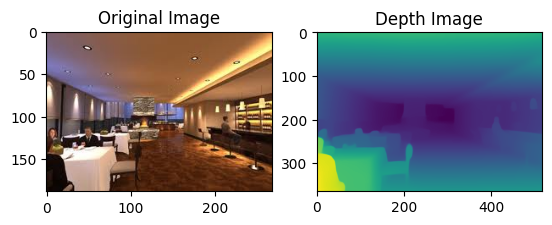

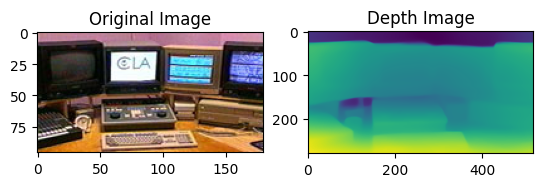

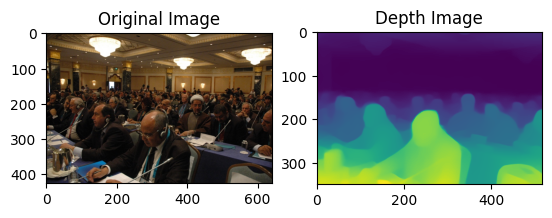

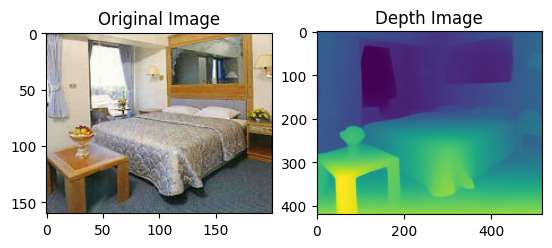

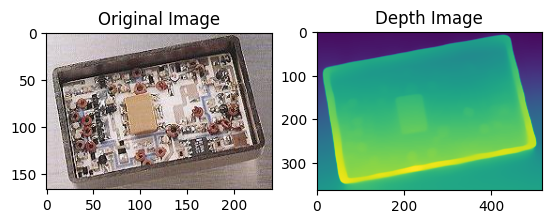

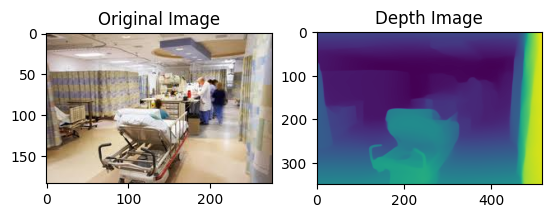

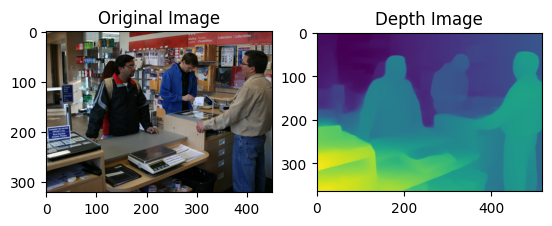

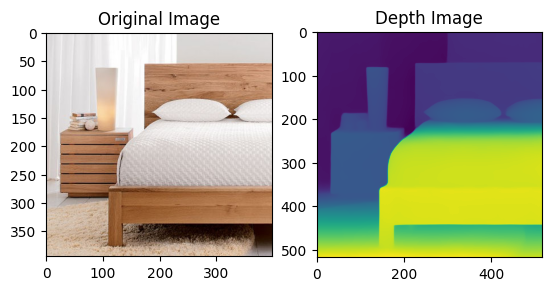

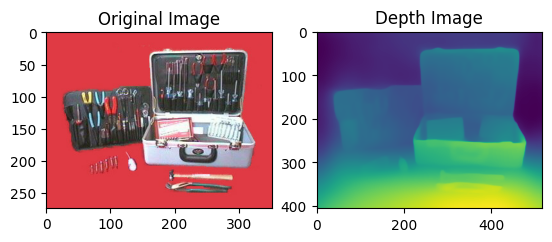

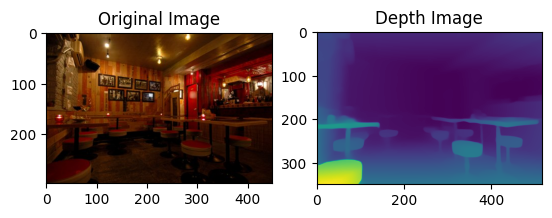

In [46]:
# plot the images and depth map side by side  in the samples list
def plot_image_and_depth(samples):
    num_samples = len(samples)
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(samples[i][0])
        axs[0].set_title('Original Image')
        axs[1].imshow(samples[i][1])
        axs[1].set_title('Depth Image')
        plt.show()

plot_image_and_depth(samples)

In [34]:
def get_intrinsics (H,W, fov=80.0):
# Intrinsics for a pinhole camera model.
# Assume fov of 55 degrees and central principal point.
    f = 0.5 * W/ np.tan (0.5 * fov * np.pi / 180.0)
    cx = 0.5*W
    cy = 0.5*H
    return np.array([[f, 0, cx],[0, f, cy],[0, 0, 1]])

In [35]:
def pixel_to_point(depth_image, camera_instrinsics = None):
    
    H, W = depth_image.shape
    if camera_instrinsics is None:
        camera_instrinsics = get_intrinsics(H,W)
    # Create a grid of points in the image plane
    fx, fy = camera_instrinsics[0,0], camera_instrinsics[1,1]
    cx, cy = camera_instrinsics[0,2], camera_instrinsics[1,2]
    
    
    x = np.linspace(0, W-1, W)
    y = np.linspace(0, H-1, H)  
    
    u, v = np.meshgrid(x,y)
    
    x_over_z = (u - cx) / fx
    y_over_z = (v - cy) / fy


    z = depth_image / np.sqrt(1 + x_over_z**2 + y_over_z**2)
    
    x = x_over_z * z
    y = y_over_z * z
    
    return x, y, z
    
    

In [56]:
def create_point_cloud(depth_image, color_image, camera_intrinsics = None, scale_ratio = 50.0):
    
    height, width = depth_image.shape
    
    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width, fov=55.0)

    color_image  = cv2.resize(color_image, (width, height))
    depth_image = np.maximum(depth_image, 1e-5)
    depth_image = scale_ratio/depth_image
    x,y,z = pixel_to_point(depth_image, camera_intrinsics)
    
    point_image = np.stack([x,y,z], axis=-1)
    
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(point_image.reshape(-1,3))
    cloud.colors = o3d.utility.Vector3dVector(color_image.reshape(-1,3)/255.0)
    
    # Masking for outdoor skys
    # mask = point_image[:,:,2] < 1e-3
    # cloud_points = o3d.utility.Vector3dVector(point_image[mask].reshape(-1,3))
    # cloud_colors = o3d.utility.Vector3dVector(color_image[mask].reshape(-1,3)/255.0)
    

    return cloud
    
            

In [57]:


# Create the outputs directory if it doesn't exist
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

def save_point_clouds(samples, sample_type="indoor"):
    for i, sample in enumerate(samples):
        color_image = sample[0]
        depth_image = sample[1]
        cloud = create_point_cloud(depth_image, color_image)
        cloud_path = output_dir / f"{sample_type}_point_cloud_{i}.ply"
        o3d.io.write_point_cloud(str(cloud_path), cloud)
        print(f"Saved {sample_type} point cloud {i} to {cloud_path}")

# Example usage:
save_point_clouds(samples, "indoor")



Saved indoor point cloud 0 to outputs\indoor_point_cloud_0.ply
Saved indoor point cloud 1 to outputs\indoor_point_cloud_1.ply
Saved indoor point cloud 2 to outputs\indoor_point_cloud_2.ply
Saved indoor point cloud 3 to outputs\indoor_point_cloud_3.ply
Saved indoor point cloud 4 to outputs\indoor_point_cloud_4.ply
Saved indoor point cloud 5 to outputs\indoor_point_cloud_5.ply
Saved indoor point cloud 6 to outputs\indoor_point_cloud_6.ply
Saved indoor point cloud 7 to outputs\indoor_point_cloud_7.ply
Saved indoor point cloud 8 to outputs\indoor_point_cloud_8.ply
Saved indoor point cloud 9 to outputs\indoor_point_cloud_9.ply


In [58]:
# Visualize a particualr indoor point cloud
cloud = o3d.io.read_point_cloud("outputs/indoor_point_cloud_5.ply")
o3d.visualization.draw_geometries([cloud])